<a href="https://colab.research.google.com/github/chaobai/Cousera-DeepLearning.AI-TensorFlow-Developer/blob/master/C2%20-%20Convolutional%20Neural%20Networks/W1/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Click the button on top that says, `Open in Colab`, to run this notebook as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

In [1]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2021-11-06 15:28:54--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.200.148.143, 2600:140e:6:9ab::e59, 2600:140e:6:98d::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.200.148.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   110MB/s    in 7.2s    

2021-11-06 15:29:01 (110 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [4]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    classes = ['cats','dogs']
    os.mkdir('training')
    os.mkdir('testing')

    for class_name in classes:
      ### START CODE HERE
        os.mkdir(os.path.join('training', class_name))
        os.mkdir(os.path.join('testing', class_name))
      ### END CODE HERE
except OSError as oe:
    print(oe)
    pass

In [5]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  
  ### START CODE HERE
  all_files = os.listdir(SOURCE)
  all_files = random.sample(all_files, len(all_files))
  num_all_files = len(all_files)
  for i, file_name in enumerate(all_files):
    if os.path.getsize(os.path.join(SOURCE, file_name)) == 0:
      print(file_name + ' is zero length, so ignoring')
      continue
    if (i < num_all_files * SPLIT_SIZE):
      copyfile(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))
    else:
      copyfile(os.path.join(SOURCE, file_name), os.path.join(TESTING, file_name))
  ### END CODE HERE

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "training/cats/"
TESTING_CATS_DIR = "testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "training/dogs/"
TESTING_DOGS_DIR = "testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [6]:
print(len(os.listdir('training/cats/')))
print(len(os.listdir('training/dogs/')))
print(len(os.listdir('testing/cats/')))
print(len(os.listdir('testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11251
11250
1249
1250


In [7]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    ### START CODE HERE
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ### END CODE HERE
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
TRAINING_DIR = "training/"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(300,300),
    batch_size=20,
    class_mode='binary'
)
VALIDATION_DIR = "testing/"
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300,300),
    batch_size=20,
    class_mode='binary'
)


# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


Note: You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [9]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15
 502/1125 [============>.................] - ETA: 1:06 - loss: 0.6804 - accuracy: 0.5991

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

1125/1125 [==============================] - 164s 118ms/step - loss: 0.6221 - accuracy: 0.6536 - val_loss: 0.5407 - val_accuracy: 0.7171
Epoch 2/15
1125/1125 [==============================] - 130s 116ms/step - loss: 0.4705 - accuracy: 0.7825 - val_loss: 0.6548 - val_accuracy: 0.7355
Epoch 3/15
1125/1125 [==============================] - 129s 114ms/step - loss: 0.3835 - accuracy: 0.8315 - val_loss: 0.3542 - val_accuracy: 0.8423
Epoch 4/15
1125/1125 [==============================] - 127s 113ms/step - loss: 0.3289 - accuracy: 0.8616 - val_loss: 0.3382 - val_accuracy: 0.8643
Epoch 5/15
1125/1125 [==============================] - 127s 113ms/step - loss: 0.2962 - accuracy: 0.8807 - val_loss: 0.2911 - val_accuracy: 0.8772
Epoch 6/15
1125/1125 [==============================] - 129s 114ms/step - loss: 0.2756 - accuracy: 0.8924 - val_loss: 0.6854 - val_accuracy: 0.8371
Epoch 7/15
1125/1125 [==============================] - 127s 113ms/step - loss: 0.2627 - accuracy: 0.9019 - val_loss: 0.363

Text(0.5, 1.0, 'Training and validation loss')

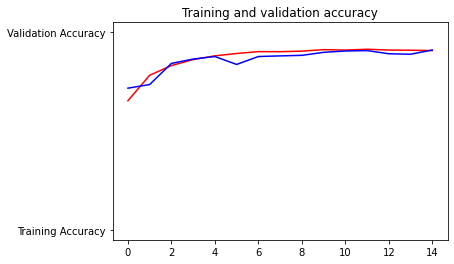

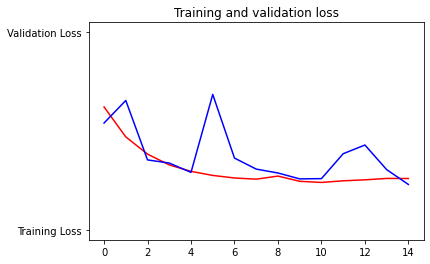

In [10]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

**Important Note:** Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a `Colab` on the `Safari` browser. For `all other broswers`, continue with the next code block and ignore the next one after it.

The ones running the `Colab` on `Safari`, comment out the code block below, uncomment the next code block and run it.

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(# YOUR CODE HERE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

SyntaxError: ignored

For those running this `Colab` on `Safari` broswer can upload the images(s) manually. Follow the instructions, uncomment the code block below and run it.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice, preferably of either a horse or a human. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [ ]:
# import numpy as np
# from keras.preprocessing import image
# import os

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#  print()
#  # predicting images
#  path = '/tmp/images/' + i
#  img = image.load_img(path, target_size=(150, 150))
#  x = image.img_to_array(img)
#  x = np.expand_dims(x, axis=0)

#  images = np.vstack([x])
#  classes = model.predict(images, batch_size=10)
#  print(classes[0])
#  if classes[0]>0.5:
#    print(i + " is a dog")
#  else:
#    print(i + " is a cat")